Caption modification as v4
Details
- Three different versions, only long distance estimation, only lat distance estimation, both
- More than 20-40m distance converted to no error, it is a rough filter implementation for TaskVLM

In [22]:
import json
import os
import sys
import pandas as pd
import numpy as np
import copy

In [23]:
data = json.load(open('/mnt/ssd1/test/nuscenes_detect_long_lat_v3.json', 'r'))
data.keys()

dict_keys(['x_features', 'captions'])

In [24]:
data_long = copy.deepcopy(data)
data_lat = copy.deepcopy(data)

In [25]:
captions = data.get('captions')
captions[:5]

['objects missed closest at right front 10-20m',
 'objects missed closest at left front 10-20m',
 'objects missed closest at right front 10-20m',
 'objects missed closest at left back 10-20m',
 'objects missed closest at left back 10-20m']

In [30]:
np.unique(captions)

array(['no object detections missed in the scene',
       'objects missed closest at left back 10-20m',
       'objects missed closest at left back 20-40m',
       'objects missed closest at left back 40-80m',
       'objects missed closest at left back 5-10m',
       'objects missed closest at left back <5m',
       'objects missed closest at left back >80m',
       'objects missed closest at left front 10-20m',
       'objects missed closest at left front 20-40m',
       'objects missed closest at left front 40-80m',
       'objects missed closest at left front 5-10m',
       'objects missed closest at left front <5m',
       'objects missed closest at left front >80m',
       'objects missed closest at right back 10-20m',
       'objects missed closest at right back 20-40m',
       'objects missed closest at right back 40-80m',
       'objects missed closest at right back 5-10m',
       'objects missed closest at right back <5m',
       'objects missed closest at right back >80m',
 

In [31]:
def move_to_safe(s):
    words=s.split()
    limit = ['20-40m','40-80m','>80m']
    for word in words:
        if word in limit:
           return "no object detections missed in the scene"
    return s
captions= list(map(move_to_safe, captions))
np.unique(captions)

array(['no object detections missed in the scene',
       'objects missed closest at left back 10-20m',
       'objects missed closest at left back 5-10m',
       'objects missed closest at left back <5m',
       'objects missed closest at left front 10-20m',
       'objects missed closest at left front 5-10m',
       'objects missed closest at left front <5m',
       'objects missed closest at right back 10-20m',
       'objects missed closest at right back 5-10m',
       'objects missed closest at right back <5m',
       'objects missed closest at right front 10-20m',
       'objects missed closest at right front 5-10m',
       'objects missed closest at right front <5m'], dtype='<U44')

I will keep the stats calculations down, but will do the fixes for the new captions here

First, remove left right, then will change based on exact patterns

In [32]:
captions_long = list(map(lambda x: x.replace('left',""), captions))
captions_long = list(map(lambda x: x.replace('right',""), captions_long))
captions_long = list(map(lambda x: x.replace('  '," "), captions_long))
np.unique(captions_long)

array(['no object detections missed in the scene',
       'objects missed closest at back 10-20m',
       'objects missed closest at back 5-10m',
       'objects missed closest at back <5m',
       'objects missed closest at front 10-20m',
       'objects missed closest at front 5-10m',
       'objects missed closest at front <5m'], dtype='<U40')

In [34]:
captions_lat = list(map(lambda x: x.replace('front',""), captions))
captions_lat = list(map(lambda x: x.replace('back',""), captions_lat))
captions_lat = list(map(lambda x: x.replace('  '," "), captions_lat))
np.unique(captions_lat)

array(['no object detections missed in the scene',
       'objects missed closest at left 10-20m',
       'objects missed closest at left 5-10m',
       'objects missed closest at left <5m',
       'objects missed closest at right 10-20m',
       'objects missed closest at right 5-10m',
       'objects missed closest at right <5m'], dtype='<U40')

In [46]:
#Distribution of captions
from pprint import pprint
values, counts = np.unique(captions_long, return_counts=True)
print("Long Only")
pprint(dict(zip(values, counts)))
values2, counts2 = np.unique(captions_lat, return_counts=True)
print("Lat Only")
pprint(dict(zip(values2, counts2)))
print("Both")
values3, counts3 = np.unique(captions, return_counts=True)
pprint(dict(zip(values3, counts3)))



Long Only
{'no object detections missed in the scene': 11307,
 'objects missed closest at back 10-20m': 7748,
 'objects missed closest at back 5-10m': 2232,
 'objects missed closest at back <5m': 306,
 'objects missed closest at front 10-20m': 7784,
 'objects missed closest at front 5-10m': 2374,
 'objects missed closest at front <5m': 383}
Lat Only
{'no object detections missed in the scene': 11307,
 'objects missed closest at left 10-20m': 7434,
 'objects missed closest at left 5-10m': 2051,
 'objects missed closest at left <5m': 395,
 'objects missed closest at right 10-20m': 8098,
 'objects missed closest at right 5-10m': 2555,
 'objects missed closest at right <5m': 294}
Both
{'no object detections missed in the scene': 11307,
 'objects missed closest at left back 10-20m': 3709,
 'objects missed closest at left back 5-10m': 950,
 'objects missed closest at left back <5m': 162,
 'objects missed closest at left front 10-20m': 3725,
 'objects missed closest at left front 5-10m': 1101

In [45]:
def get_error_ratio(caps,mode):
    missed_count = 0
    no_missed_count = 0
    for cap in caps:
        if "no object" in cap:
            no_missed_count += 1
        else:
            missed_count += 1
    print('missed_count:', missed_count)
    print('no_missed_count:', no_missed_count)
    print("missed_rate", missed_count/len(caps))
    print("no_missed_rate", no_missed_count/len(caps))
    print("---")
def get_location_ratio(caps,mode):
    loc = [x for x in caps if "no object" not in x]
    if mode == "long" or mode == "all":
        front_count = len([x for x in loc if "front" in x])
        back_count = len([x for x in loc if "back" in x])
        print("Long label ratio")
        print(f"Front count (Ratio): {front_count} ({front_count/len(loc)})")
        print(f"Back count (Ratio): {back_count} ({back_count/len(loc)})")
        print("---")
    if mode == "lat" or mode == "all":
        left_count = len([x for x in loc if "left" in x])
        right_count = len([x for x in loc if "right" in x])
        print("Lat label ratio")
        print(f"Left count (Ratio): {left_count} ({left_count/len(loc)})")
        print(f"Right count (Ratio): {right_count} ({right_count/len(loc)})")
        print("---")
def get_distance_ratio(caps):
    distances = [x for x in caps if "no object" not in x]
    distance = [x.split()[-1] for x in distances]
    values, counts = np.unique(distance, return_counts=True)
    for i in range(len(values)):
        print(f"{values[i]} count (Ratio): {counts[i]} ({counts[i]/len(distance)})")
    # print("Distance label ratio")
    # print(f"Distance count (Ratio): {len(distance)} ({len(distance)/len(loc)})")
    # print("---")
get_error_ratio(captions_long,"long")
get_location_ratio(captions,"all")
get_distance_ratio(captions)

missed_count: 20827
no_missed_count: 11307
missed_rate 0.6481297068525549
no_missed_rate 0.35187029314744506
---
Long label ratio
Front count (Ratio): 10541 (0.506121861045758)
Back count (Ratio): 10286 (0.4938781389542421)
---
Lat label ratio
Left count (Ratio): 9880 (0.47438421280069143)
Right count (Ratio): 10947 (0.5256157871993086)
---
10-20m count (Ratio): 15532 (0.7457627118644068)
5-10m count (Ratio): 4606 (0.22115523119028185)
<5m count (Ratio): 689 (0.033082056945311376)


In [38]:
data_long['captions'] = captions_long
data_lat['captions'] = captions_lat
data['captions'] = captions
with open('/mnt/ssd1/test/nuscenes_detect_long_lat_v4.json', 'w') as f:
    json.dump(data, f)
with open('/mnt/ssd1/test/nuscenes_detect_long_v4.json', 'w') as f:
    json.dump(data_long, f)
with open('/mnt/ssd1/test/nuscenes_detect_lat_v4.json', 'w') as f:
    json.dump(data_lat, f)

In [42]:
#Some sanity check
print(len(data['captions']),len(data['x_features']))
print(len(data_long['captions']),len(data_long['x_features']))
print(len(data_lat['captions']),len(data_lat['x_features']))

32134 32134
32134 32134
32134 32134


Some pre processing to identify the distribution for each class

In [8]:
items = list(map(lambda x: x.split(" "), captions))
print(len(items))
items[:5]

32134


[['objects', 'missed', 'closest', 'at', 'right', 'front', '10-20m'],
 ['objects', 'missed', 'closest', 'at', 'left', 'front', '10-20m'],
 ['objects', 'missed', 'closest', 'at', 'right', 'front', '10-20m'],
 ['objects', 'missed', 'closest', 'at', 'left', 'back', '10-20m'],
 ['objects', 'missed', 'closest', 'at', 'left', 'back', '10-20m']]

In [13]:
error_clases = list(filter(lambda x: "no" not in x, items))
len(error_clases)

31845

In [10]:
labels_only = list(map(lambda x: x[4:], clases))
labels_only[:5]

[['right', 'front', '10-20m'],
 ['left', 'front', '10-20m'],
 ['right', 'front', '10-20m'],
 ['left', 'back', '10-20m'],
 ['left', 'back', '10-20m']]

In [11]:
df = pd.DataFrame(labels_only)
df.head()


,0,1,2
0,right,front,10-20m
1,left,front,10-20m
2,right,front,10-20m
3,left,back,10-20m
4,left,back,10-20m


In [12]:
DETECTION_TYPE_DICT = { # x2 detection types
                      'no object detections missed': 0, 
                      'objects missed closest at': 1
                      }

NON_DETECTION_PHRASE = 'objects missed closest at' # used to split caption

LOC_LONG_DICT = { # x2 longitudinal types
                'front': 0,
                'back': 1
                }

LOC_LAT_DICT = { # x2 lateral types
                'left': 0,
                'right': 1
                }

DIST_DICT = {
            '<5m': 0,
            '5-10m': 1,
            '10-20m': 2,
            '20-40m':3,
            '40-80m': 4,
            '>80m': 5,
            }
## nuscenes_detect_long_v4

In [75]:
df[0] = df[0].replace(LOC_LAT_DICT)
df[1] = df[1].replace(LOC_LONG_DICT)
df[2] = df[2].replace(DIST_DICT)
df.head()

,0,1,2
0,1,0,2
1,0,0,2
2,1,0,2
3,0,1,2
4,0,1,2


In [78]:
#plot histogram of each column
(df[2] > 2).sum()

11018

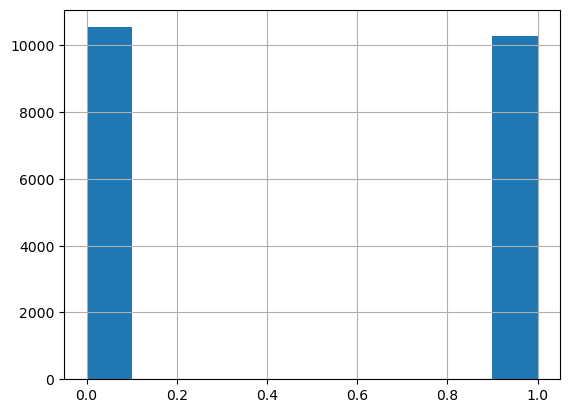

In [82]:
df[df[2]<3][1].hist()

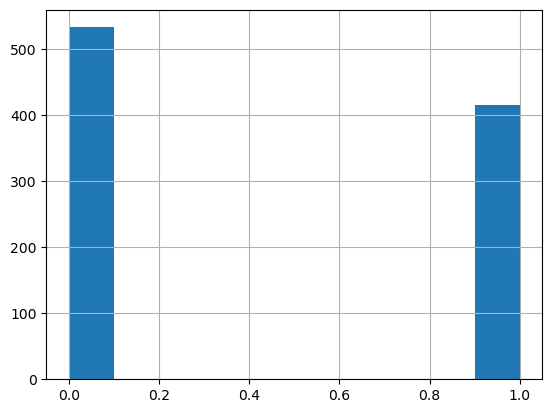

In [83]:
df[df[2]>3][1].hist()